In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt
import plotly

# Other
import os, sys
import time

import copy
import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
from noisyopt import minimizeSPSA
import optuna # Automatic tuning tool

import multiprocessing

import warnings
warnings.filterwarnings("ignore", message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.")


In [6]:

def qml_build_H(N, lam, J):
    '''
    Set up Hamiltonian: 
            H = lam*Σsigma^i_z - J*Σsigma^i_x*sigma^{i+1}_ 
    '''
    # Interaction of spins with magnetic field
    H = + lam * qml.PauliZ(0)
    for i in range(1,N):
        H = H + lam * qml.PauliZ(i)
        
    # Interaction between spins:
    for i in range(0,N-1):
        H = H + J*(-1)*( qml.PauliX(i) @ qml.PauliX(i+1) )
    
    return H

def circuit_block_1(N, param, index = 0, p_noise = 0):
    '''
    RY
    
    shift_invariance = 0: Each wire permorms independent rotations.
    shift_invariance = 1: Same rotation for odd and even wires,
                         expect for the first and last that have unique
                         rotation.
    shift_invariance = 2: Same rotation for each wire
    '''
    noise = True
    if p_noise == 0: noise = False # Remove BitFlip and PhaseFlip if we are not using default.mixed
    
    # Apply RX and RY to each wire:
    for spin in range(N):
        qml.RY(param[index + spin],   wires = spin)
        if noise: qml.PhaseFlip(p_noise, wires = spin); qml.BitFlip(p_noise, wires = spin)
            
    return index + N

def circuit_block_2(N, param, index = 0, p_noise = 0):
    '''
    RY
    
    shift_invariance = 0: Each wire permorms independent rotations.
    shift_invariance = 1: Same rotation for odd and even wires,
                         expect for the first and last that have unique
                         rotation.
    shift_invariance = 2: Same rotation for each wire
    '''
    noise = True
    if p_noise == 0: noise = False # Remove BitFlip and PhaseFlip if we are not using default.mixed
    
    # Apply RX and RY to each wire:
    for spin in range(N):
        qml.RY(param[index + spin],   wires = spin)
        qml.RX(param[index + N + spin],   wires = spin)
        if noise: qml.PhaseFlip(p_noise, wires = spin); qml.BitFlip(p_noise, wires = spin)
            
    return index + 2*N


def circuit_block_3(N, param, index = 0, p_noise = 0):
    '''
    RY
    
    shift_invariance = 0: Each wire permorms independent rotations.
    shift_invariance = 1: Same rotation for odd and even wires,
                         expect for the first and last that have unique
                         rotation.
    shift_invariance = 2: Same rotation for each wire
    '''
    noise = True
    if p_noise == 0: noise = False # Remove BitFlip and PhaseFlip if we are not using default.mixed
    
    # Apply RX and RY to each wire:
    for spin in range(N):
        #qml.RZ(param[index + N + spin],   wires = spin)
        qml.RX(param[index + spin],   wires = spin)
        if noise: qml.PhaseFlip(p_noise, wires = spin); qml.BitFlip(p_noise, wires = spin)
            
    return index + N

def circuit_block_4(N, param, index = 0, p_noise = 0):
    '''
    RX + RY
    '''
    noise = True
    if p_noise == 0: noise = False # Remove BitFlip and PhaseFlip if we are not using default.mixed
    
    # Apply RX and RY to each wire:
    for spin in range(N):
        qml.RZ(param[index + spin],     wires = spin)
        if noise: qml.PhaseFlip(p_noise, wires = spin); qml.BitFlip(p_noise, wires = spin)
        qml.RX(param[index + N + spin], wires = spin)
        if noise: qml.PhaseFlip(p_noise, wires = spin); qml.BitFlip(p_noise, wires = spin)
            
    return index + 2*N

def circuit_entanglement(N, params, index, p_noise_ent = 0, going_down = True):
    # Apply entanglement to the neighbouring spins
    noise = True
    if p_noise_ent == 0: noise = False # Remove BitFlip and PhaseFlip if we are not using default.mixed
    
    if going_down:
        for spin in range(0,N-1):
            qml.IsingZZ(params[index+spin], wires = [spin, spin+1])
            #qml.RX(params[index+spin], wires = spin+1)
            
            if noise: qml.PhaseFlip(p_noise_ent, wires = spin+1); qml.BitFlip(p_noise_ent, wires = spin+1)
            
    else:
        for spin in range(N-1,0,-1):
            qml.CNOT(wires = [spin, spin-1])
            #qml.RX(params[index+spin], wires = spin-1)
            
            if noise: qml.PhaseFlip(p_noise_ent, wires = spin-1); qml.BitFlip(p_noise_ent, wires = spin-1)
            
    return index + N - 1

def circuit_entanglement2(N, params, index, p_noise_ent = 0, going_down = True):
    # Apply entanglement to the neighbouring spins
    noise = True
    if p_noise_ent == 0: noise = False # Remove BitFlip and PhaseFlip if we are not using default.mixed
    
    for spin in range(0,N-1):
        qml.CNOT(wires = [spin, spin+1])
        if noise: qml.PhaseFlip(p_noise_ent, wires = spin+1); qml.BitFlip(p_noise_ent, wires = spin+1)
            
    return index


def vqe_circuit1(N, params, p_noise = 0, p_noise_ent = 0):
    index = circuit_block_2(N, params, p_noise = p_noise)
    qml.Barrier()
    index = circuit_entanglement2(N, params, index, p_noise_ent)
    qml.Barrier()
    index = circuit_block_2(N, params, index, p_noise = p_noise)
    qml.Barrier()
    index = circuit_entanglement2(N, params, index, p_noise_ent)
    qml.Barrier()
    index = circuit_block_1(N, params, index, p_noise = p_noise)
    return index

def vqe_circuit2(N, params, p_noise = 0, p_noise_ent = 0):
    index = circuit_block_3(N, params, p_noise = p_noise)
    qml.Barrier()
    index = circuit_entanglement(N, params, index, p_noise_ent)
    qml.Barrier()
    index = circuit_block_3(N, params, index, p_noise = p_noise)
    qml.Barrier()
    index = circuit_entanglement(N, params, index, p_noise_ent)
    qml.Barrier()
    index = circuit_block_3(N, params, index, p_noise = p_noise)
    index = circuit_block_4(N, params, index, p_noise = p_noise)
    
    return index


In [75]:
def vqe_train_jax_recycled(step_size, n_epochs, N, J, l_steps, device, vqe_circuit_fun, reg = 0, circuit = False, plots = False, parameter_info = True):
    # IDEA: Making the Jax version of a VQE eigensolver is a bit less intuitive that in the QCNN learning function,
    #       since here we have l_steps different circuit since each output of the circuit is <psi|H|psi> where H,
    #       changes for each datapoints.
    #       Here the output of each circuit is |psi>, while the Hs is moved to the loss function
    #       <PSI|Hs|PSI> is computed through 2 jax.einsum
    
    # circuit functions returns the number of parameters needed for the circuit itself
    n_params = vqe_circuit_fun(N, [0]*1000)
    
    if parameter_info:
        print('+--- PARAMETERS ---+')
        print('step_size      = {0} (Step size of the optimizer)'.format(step_size))
        print('n_epochs       = {0} (# epochs for the other GSs)'.format(n_epochs))
        print('N              = {0} (Number of spins of the system)'.format(N))
    
    ### JAX FUNCTIONS ###
    
    # Circuit that returns the state |psi> 
    @qml.qnode(device, interface="jax")
    def vqe_state(vqe_params, N):
        vqe_circuit_fun(N, vqe_params)
        
        return qml.state()
    
    if circuit:
        # Display the circuit
        print('+--- CIRCUIT ---+')
        drawer = qml.draw(vqe_state)
        print(drawer(np.arange(n_params), N))
    
    
    j_vqe_state = jax.jit(lambda p: vqe_state(p, N) )
    v_vqe_state = jax.vmap(lambda p: vqe_state(p, N) )
    
    # computes <psi|H|psi>
    def compute_E(state, Hmat):
        return jnp.conj(state) @ Hmat @ state
    
    # vmapped function for <psi|H|psi>
    v_compute_E = jax.vmap(compute_E, in_axes=(0,0) )
    j_compute_E = jax.jit(compute_E)
    
    # Computes MSE of the true energies - vqe energies: function to minimize
    def update(param, Hmat):
        pred_state = j_vqe_state(param)
        vqe_e = j_compute_E(pred_state, Hmat)
        
        return jnp.real(vqe_e)
    
    # Same function as above but returns the energies not MSE
    def compute_vqe(param, Hmat):
        pred_states = j_vqe_state(param)
        vqe_e = j_compute_E(pred_states, Hmat)

        return jnp.real(vqe_e)
    
    # Grad function of the MSE, used in updating the parameters
    jd_update = jax.jit(jax.grad(update))
    j_compute_vqe = jax.jit(compute_vqe)
    v_compute_vqe = jax.vmap(compute_vqe, in_axes=(0,0) )
    
    lams = np.linspace(0, 2*J, l_steps)
    
    # For each lamda create optimizer and H
    Hs    = []
    Hsmat = []
    opts  = []
    energy_err  = [0]*(len(lams))
    true_e = []
    
    for i, lam in enumerate(lams):
        # Pennylane matrices
        Hs.append(qml_build_H(N, float(lam), float(J) ))
        # True groundstate energies
        true_e.append(np.min(qml.eigvals(Hs[i])) )
        # Standard matrix for of the hamiltonians
        Hsmat.append(qml.matrix(Hs[-1]) )
    
    true_e = jnp.array(true_e)
    Hsmat = jnp.array(Hsmat)
    
    progress = tqdm.tqdm(enumerate(lams), position=0, leave=True)
    
    params = []
    
    param = jnp.array(np.random.rand(n_params))
    for idx, lam in progress: 
        for it in range(n_epochs):
            param -= step_size*jd_update(param, Hsmat[idx])
            
        params.append(copy.copy(param))
        progress.set_description('{0}/{1}'.format(idx, len(lams)) )
            
    params = jnp.array(params)
    vqe_e = v_compute_vqe(params, Hsmat)
    
    if plots:
        fig, ax = plt.subplots(4, 1, figsize=(12,14))
                          
        ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
        ax[0].plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
        ax[0].plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
        ax[0].grid(True)
        ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$E(\lambda)$')
        ax[0].legend()
        
        true_e = np.array(true_e)
        vqe_e = np.array(vqe_e)
        accuracy = np.abs((true_e-vqe_e)/true_e)
        ax[1].fill_between(lams, 0.01, max(np.max(accuracy),0.01), color = 'r', alpha = 0.3 )
        ax[1].fill_between(lams, .01, min(np.min(accuracy),0), color = 'green', alpha = 0.3 )
        ax[1].axhline(y=0.01, color='r', linestyle='--')
        ax[1].scatter(lams, accuracy)
        ax[1].grid(True)
        ax[1].set_title('Accuracy of VQE'.format(N,J))
        ax[1].set_xlabel(r'$\lambda$')
        ax[1].set_ylabel(r'$|(E_{vqe} - E_{true})/E_{true}|$')
        
        states = v_vqe_state(params)
        rho_dist = [np.mean(np.square(np.real(states[k+1] - states[k]))) for k in range(l_steps-1)]
            
        ax[2].set_title('Mean square distance between consecutives density matrices')
        ax[2].plot(np.linspace(0,2*J, num=l_steps-1), rho_dist, '-o')
        ax[2].grid(True)
        ax[2].axvline(x=J, color='gray', linestyle='--')
        ax[2].set_xlabel(r'$\lambda$')
        
        plt.tight_layout()
        
    ys = []
    for l in lams:
        ys.append(0) if l <= J else ys.append(1)
        
    return vqe_e, params, ys   

In [80]:
N = 8
J = 1

n_epochs = 10
lr = 0.25
l_steps = 100
reg = 1000

device_jax = qml.device("default.qubit.jax", wires = N, shots = None)

+--- PARAMETERS ---+
step_size      = 0.25 (Step size of the optimizer)
n_epochs       = 10 (# epochs for the other GSs)
N              = 8 (Number of spins of the system)
+--- CIRCUIT ---+
0: ──RY(0.00)──RX(8.00)───||─╭C────────────────────||──RY(16.00)──RX(24.00)──||─╭C──────────────────
1: ──RY(1.00)──RX(9.00)───||─╰X─╭C─────────────────||──RY(17.00)──RX(25.00)──||─╰X─╭C───────────────
2: ──RY(2.00)──RX(10.00)──||────╰X─╭C──────────────||──RY(18.00)──RX(26.00)──||────╰X─╭C────────────
3: ──RY(3.00)──RX(11.00)──||───────╰X─╭C───────────||──RY(19.00)──RX(27.00)──||───────╰X─╭C─────────
4: ──RY(4.00)──RX(12.00)──||──────────╰X─╭C────────||──RY(20.00)──RX(28.00)──||──────────╰X─╭C──────
5: ──RY(5.00)──RX(13.00)──||─────────────╰X─╭C─────||──RY(21.00)──RX(29.00)──||─────────────╰X─╭C───
6: ──RY(6.00)──RX(14.00)──||────────────────╰X─╭C──||──RY(22.00)──RX(30.00)──||────────────────╰X─╭C
7: ──RY(7.00)──RX(15.00)──||───────────────────╰X──||──RY(23.00)──RX(31.00)──||───────────────────╰X

─

99/100: : 100it [00:05, 18.91it/s]


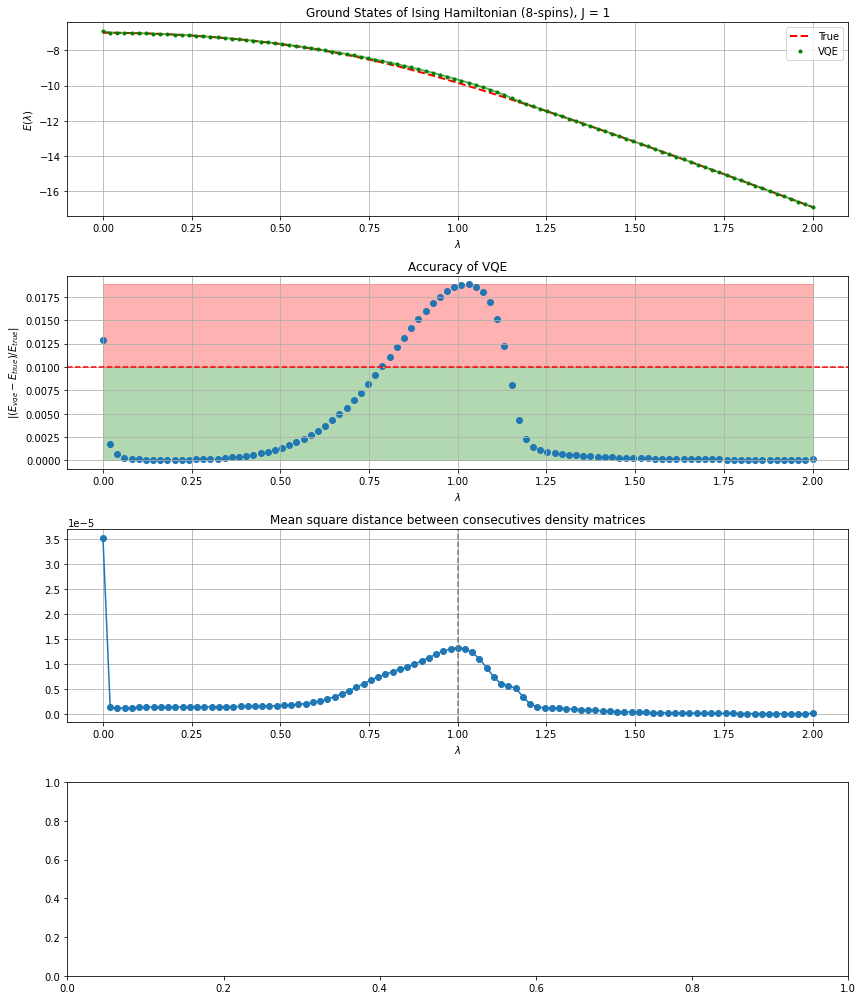

In [81]:
vqe_e, params, ys = jax_train_recycle(lr, n_epochs, N, J, l_steps, device_jax, vqe_circuit1, reg = reg, plots = True, circuit = True)

In [17]:
def jax_train(step_size, n_epochs, N, J, l_steps, device, vqe_circuit_fun, reg = 0, circuit = False, plots = False, parameter_info = True):
    # IDEA: Making the Jax version of a VQE eigensolver is a bit less intuitive that in the QCNN learning function,
    #       since here we have l_steps different circuit since each output of the circuit is <psi|H|psi> where H,
    #       changes for each datapoints.
    #       Here the output of each circuit is |psi>, while the Hs is moved to the loss function
    #       <PSI|Hs|PSI> is computed through 2 jax.einsum
    
    # circuit functions returns the number of parameters needed for the circuit itself
    n_params = vqe_circuit_fun(N, [0]*1000)
    
    if parameter_info:
        print('+--- PARAMETERS ---+')
        print('step_size      = {0} (Step size of the optimizer)'.format(step_size))
        print('n_epochs       = {0} (# epochs for the other GSs)'.format(n_epochs))
        print('N              = {0} (Number of spins of the system)'.format(N))
    
    ### JAX FUNCTIONS ###
    
    # Circuit that returns the state |psi> 
    @qml.qnode(device, interface="jax")
    def vqe_state(vqe_params, N):
        vqe_circuit_fun(N, vqe_params)
        
        return qml.state()
    
    if circuit:
        # Display the circuit
        print('+--- CIRCUIT ---+')
        drawer = qml.draw(vqe_state)
        print(drawer(np.arange(n_params), N))
    
    
    # vmap of the circuit
    v_vqe_state = jax.vmap(lambda v:  vqe_state(v, N), in_axes=(0))
    
    # jitted vmap of the circuit
    jv_vqe_state = jax.jit(v_vqe_state)
    
    # computes <psi|H|psi>
    def compute_E(state, Hmat):
        return jnp.conj(state) @ Hmat @ state
    
    # vmapped function for <psi|H|psi>
    v_compute_E = jax.vmap(compute_E, in_axes=(0,0) )
    
    # Regularizator of the optimizer
    def compute_diff_states(states):
        return jnp.mean(jnp.square(jnp.diff(jnp.real(states), axis = 1) ) )
    
    # Computes MSE of the true energies - vqe energies: function to minimize
    def update(params):
        pred_states = v_vqe_state(params)
        vqe_e = v_compute_E(pred_states, Hsmat)
        
        if reg != 0:
            return jnp.mean(jnp.real(vqe_e)) + reg * compute_diff_states(pred_states)
        else:
            return jnp.mean(jnp.real(vqe_e))
    
    # Same function as above but returns the energies not MSE
    def compute_vqe(params):
        pred_states = v_vqe_state(params)
        vqe_e = v_compute_E(pred_states, Hsmat)

        return jnp.real(vqe_e)
    
    # Grad function of the MSE, used in updating the parameters
    jd_update = jax.jit(jax.grad(update))
    
    j_compute_vqe = jax.jit(compute_vqe)
    
    lams = np.linspace(0, 2*J, l_steps)
    
    # Prepare initial parameters randomly for each datapoint/state
    # We start from the same datapoint
    param = np.random.rand(n_params)
    params0 = []
    for _ in lams:
        params0.append(param)
    
    params = jnp.array(params0)
    
    # For each lamda create optimizer and H
    Hs    = []
    Hsmat = []
    opts  = []
    energy_err  = [0]*(len(lams))
    true_e = []
    
    for i, lam in enumerate(lams):
        # Pennylane matrices
        Hs.append(qml_build_H(N, float(lam), float(J) ))
        # True groundstate energies
        true_e.append(np.min(qml.eigvals(Hs[i])) )
        # Standard matrix for of the hamiltonians
        Hsmat.append(qml.matrix(Hs[-1]) )
    
    true_e = jnp.array(true_e)
    Hsmat = jnp.array(Hsmat)
    
    progress = tqdm.tqdm(range(n_epochs), position=0, leave=True)
    
    MSE = []
    for it in progress:
        params -= step_size*jd_update(params)
        # I want to skip when it == 0
        if (it+1) % 1000 == 0:
            MSE.append( jnp.mean(jnp.square(j_compute_vqe(params)- true_e) )  )
            
            # Update progress bar
            progress.set_description('Cost: {0}'.format(MSE[-1]) )
            
    vqe_e = j_compute_vqe(params)
    
    if plots:
        fig, ax = plt.subplots(4, 1, figsize=(12,18.6))
                          
        ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
        ax[0].plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
        ax[0].plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
        ax[0].grid(True)
        ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$E(\lambda)$')
        ax[0].legend()
        
        ax[1].plot(np.arange(len(MSE))*1000, MSE, '.', color='orange', ms = 7 )
        ax[1].plot(np.arange(len(MSE))*1000, MSE, color='orange', alpha=0.4)
        ax[1].set_title('Convergence of VQE')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('MSE')
        ax[1].grid(True)
        ax[1].axhline(y=0, color='r', linestyle='--')
        
        true_e = np.array(true_e)
        vqe_e = np.array(vqe_e)
        accuracy = np.abs((true_e-vqe_e)/true_e)
        ax[2].fill_between(lams, 0.01, max(np.max(accuracy),0.01), color = 'r', alpha = 0.3 )
        ax[2].fill_between(lams, .01, min(np.min(accuracy),0), color = 'green', alpha = 0.3 )
        ax[2].axhline(y=0.01, color='r', linestyle='--')
        ax[2].scatter(lams, accuracy)
        ax[2].grid(True)
        ax[2].set_title('Accuracy of VQE'.format(N,J))
        ax[2].set_xlabel(r'$\lambda$')
        ax[2].set_ylabel(r'$|(E_{vqe} - E_{true})/E_{true}|$')
        
        states = jv_vqe_state(params)
        rho_dist = [np.mean(np.square(np.real(states[k+1] - states[k]))) for k in range(l_steps-1)]
            
        ax[3].set_title('Mean square distance between consecutives density matrices')
        ax[3].plot(np.linspace(0,2*J, num=l_steps-1), rho_dist, '-o')
        ax[3].grid(True)
        ax[3].axvline(x=J, color='gray', linestyle='--')
        ax[3].set_xlabel(r'$\lambda$')
        
        plt.tight_layout()
        
    ys = []
    for l in lams:
        ys.append(0) if l <= J else ys.append(1)
        
    return vqe_e, params, ys   

In [24]:
vqe_data_x = params 
vqe_data_y = ys
    
vqe_data = []
for i in range(len(vqe_data_x)):
    vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
    
vqe_data = np.array(vqe_data)

joblib.dump(vqe_data, '/data/smonaco/data.job')

/home/saverio/Desktop/CERN/code/qua/lib/python3.10/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


FileNotFoundError: [Errno 2] No such file or directory: '/data/smonaco/data.job'